# Arraylake for ALIVE zarr arrays
Danielle Losos (losos@wisc.edu)

Paul Stoy (pcstoy@wisc.edu)

Sophie Hoffman (shoffman22@wisc.edu)

Sadegh Ranjbar (sranjbar@wisc.edu)

& Ryan Abernathey (ryan@earthmover.io)

As before, first: MAKE A COPY OF THIS NOTEBOOK!
1. File -> Save a copy in Drive -> Give this new copy a name that you like
2. If necessary, open the new file (located in the "Colab notebooks" folder in "My Drive")

Note: Colab will likely run best in Google Chrome.

This lesson will teach you how to work with [zarr](https://zarr.dev/) libraries created using [Arraylake](https://docs.earthmover.io/) by [earthmover](https://earthmover.io/). We will use a zarr library that contains [GPP estimates](https://alive-abi.github.io/alive/daily-GPP.html) from the Advanced Baseline Imager Live Imaging of Vegetated Ecosystems ([ALIVE](https://alive-abi.github.io/alive/index.html)) workflow that we call 'ALIVE$_{GPP}$', also described in this [google slides presentation](https://docs.google.com/presentation/d/1PJclqluGFHkp9LpHZ85_pgL8lFLLaAMsQcEGZ2DIGSU/edit#slide=id.p1) that we created for the workshop

To create ALIVE$_{GPP}$, we collected observations and data products from the [Advanced Baseline Imager](https://www.goes-r.gov/spacesegment/abi.html) on the [Geostationary Operational Environmental Satellites - R Series (GOES-R)](https://www.goes-r.gov/) from pixels that contain Ameriflux and NEON, Inc. towers as described in [Losos et al. (2024)](https://www.nature.com/articles/s41597-024-03071-z). We then used a machine learning model, specifically a [gradient boosting model](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4671918), to estimate GPP at the native temporal resolution of the ABI CONUS scene, every 5 minutes, as described in our recent [preprint](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4884876).

The volume of data generated by sub-daily flux estimates is prohibitive for many conventional applications. We also want to create near-real time data products that we hope are useful for management, data assimilation, public outreach, and more. Honestly, cloud-native workflows help democratize science. More people can work with big data. For these reasons, zarr libraries are a logical choice.

First, we need to import some common [python libraries](https://www.geeksforgeeks.org/libraries-in-python/) including [numpy](https://en.wikipedia.org/wiki/NumPy), [pandas](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/), and [datetime](https://docs.python.org/3/library/datetime.html). It can also help to turn off warnings.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#I like to set the matplotlib font size to something more readable
plt.rcParams.update({'font.size': 16})

import matplotlib.animation as animation
import datetime
import time
import warnings
warnings.filterwarnings("ignore")

We will also need to import the zarr experimental API from [os](https://docs.python.org/3/library/os.html), [xarray](https://docs.xarray.dev/en/stable/) to work with zarr files, and also [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) because we'll be relying a bit on the [Google Cloud Platform](https://en.wikipedia.org/wiki/Google_Cloud_Platform). As it happens we will use a previous verion of fsspec to make everything work and will have to install it. This will take a few seconds.

In [ ]:
!pip install --upgrade fsspec==2024.6.1 aiohttp==3.9.5 requests==2.31.0
import os
os.environ['ZARR_V3_EXPERIMENTAL_API'] = '1'
import xarray as xr
import fsspec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.


For geospatial and climate data, [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [metpy](https://unidata.github.io/MetPy/latest/index.html) are necessary, and need to first be installed then imported into colab. You'll probably want to minimize the code cell outputs by clicking on the box/arrow button below the [code block](https://colab.research.google.com/notebooks/markdown_guide.ipynb).

In [ ]:
!pip install cartopy
!pip install metpy
import cartopy.crs as ccrs
import metpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.3/301.3 kB 13.5 MB/s eta 0:00:00


Now, we need to install and configure Arraylake. Follow the instructions to enter your unique authentication code, then hit return. We will use our 2024 ALIVE repository of GPP estimates that is added to every evening. If you would like access, please write Paul Stoy at pcstoy@wisc.edu.

In [ ]:
!pip install arraylake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.0/127.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.2/210.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.3 MB/s

In [ ]:
from arraylake import Client, config

config.set({"s3.anon": True})
client = Client()

In [ ]:
# will start an interactive login dialog in the notebook
client.login()

🔑 Authorize ──────────────────────────────────────────────────────────────────────────────────────────────────────

Copy and paste the following ]8;id=966931;https://production.auth.earthmover.io/oauth2/authorize?client_id=28tmicacorl6k3jh9m5ho0lbln&response_type=code&scope=email+openid+profile+aws.cognito.signin.user.admin&redirect_uri=https%3A%2F%2Fapi.earthmover.io%2Foauth_callback\🔗 link]8;;\ into your browser:

https://production.auth.earthmover.io/oauth2/authorize?client_id=28tmicacorl6k3jh9m5ho0lbln&response_type=code&scope=email+openid+profile+aws.cognito.signin.user.admin&redirect_uri=https%3A%2F%2Fapi.earthmover.io%2Foauth_callback

⬇ Then enter the code below. Visit ]8;id=38014;https://docs.earthmover.io/arraylake/org_access#authenticating-as-a-user\docs.earthmover.io]8;;\ for help.

😎 Enter your code:

c94a3482-aa16-448d-a88a-9adb8e79946e


{"id":"47d7cd2f-f958-4b1c-9172-812a0a87b758","first_name":"Danielle","family_name":"Losos","email":"losos@wisc.edu"
}

✅ Token stored at /root/.arraylake/token.json

We can now open the dataset to explore its contents and perform analyses. The public repository name is "wisc-alive/ALIVE_v1-2024"

In [ ]:
# Define repository
repo_name = "wisc-alive/ALIVE_v1-2024"
repo = client.get_repo(repo_name,read_only=True)

# Open the 2024 Zarr Array
# ds_2024 = xr.open_dataset(repo.to_xarray("daily_GPP_2024"))
ds_2024 = xr.open_dataset(
          repo.store,
          group="daily_GPP_2024",
          engine="zarr")

# Fixed Grid to Lat/Lon Functions

The following code blocks deal with shifting from the [Advanced Baseline Imager](https://www.goes-r.gov/spacesegment/abi.html) [fixed grid projection](https://www.star.nesdis.noaa.gov/atmospheric-composition-training/satellite_data_goes_imager_projection.php) to more common coordinates, and for accessing S3 buckets.

In [ ]:
# DON'T CHANGE THESE CONSTANTS
H = 35786023.0 + 6378137.0 # perspective_point_height + semi_major_axis
req = 6378137 #semi_major_axis
rpol = 6356752.31414 # semi_minor_axis
e = 0.0818191910435, # GRS-80 eccentricity
lon_0_deg = -75.0 # GOES-16 sub-sat longitude

In Python, one can define functions into which variables can be passed to return outputs. These two functions are used to convert between the ABI fixed grid to latitute and longitude, and back again. They require constants from the code block above.

In [ ]:
def ABIangle2LonLat(x, y, H, req, rpol, lon_0_deg):
    '''This function finds the latitude and longitude (degrees) of point P
    given x and y, the ABI elevation and scanning angle (radians)'''

    # Intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P

    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)

    # Calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0_deg - np.degrees( np.arctan( Sy / ( H - Sx )) )

    return (lon,lat)

In [ ]:
def LonLat2ABIangle(lon_deg, lat_deg, z, H, req, rpol, e, lon_0_deg):
    '''This function finds the ABI elevation (y) and scanning (x) angles (radians) of point P,
    given a latitude and longitude (degrees)'''

    # Convert lat and lon from degrees to radians
    lon = np.radians(lon_deg)
    lat = np.radians(lat_deg)
    lon_0 = np.radians(lon_0_deg)

    # Geocentric latitude
    lat_geo = np.arctan( (rpol**2 / req**2) * np.tan(lat) )

    # Geocentric distance to point on the ellipsoid
    _rc = rpol / np.sqrt(1 - (e**2)*(np.cos(lat_geo)**2)) # this is rc if point is on the ellipsoid
    rc = _rc + z # this is rc if the point is offset from the ellipsoid by z (meters)

    # Intermediate calculations
    Sx = H - rc * np.cos(lat_geo) * np.cos(lon - lon_0)
    Sy = -rc * np.cos(lat_geo) * np.sin(lon - lon_0)
    Sz = rc * np.sin(lat_geo)

    # Calculate x and y scan angles
    y = np.arctan( Sz / Sx )
    x = np.arcsin( -Sy / np.sqrt( Sx**2 + Sy**2 + Sz**2 ) )

    return (x,y)

This function is used to explore the contents of the S3 buckets where the ALIVE data are hosted. We use University of Wisconsin S3 buckets that are similar to the more common [Amazon S3 buckets](https://en.wikipedia.org/wiki/Amazon_S3).

In [ ]:
def list_blobs(bucket_name,file_prefix):
    storage_client = storage.Client.create_anonymous_client()
    bucket = storage_client.get_bucket(bucket_name)
    blobs = storage_client.list_blobs(bucket_name, prefix = file_prefix) # list of files from that bucket & prefix

    blob_list = list(blobs)
    count = len(blob_list)
    return(count,blob_list,bucket) # number of files, list of files, bucket name

#  Make time-series line plot

A logical place to start with zarr arrays is to plot a single pixel in the time dimension. We'll choose the NEON site [US-xUN: NEON University of Notre Dame Environmental Research Center (UNDE)](https://ameriflux.lbl.gov/sites/siteinfo/US-xUN) for consistency with the other lessons in the workshop.

We will also take advantage of the unique features of zarr libraries: we are adding 240 5-minute time layers to the ALIVE_GPP_2024 library every evening. There's no reason to not explore the past few days of GPP estimates, starting with the Fourth of July, 2024.

In [ ]:
# Geographical coordinates of US-xUN
site_lon =  -89.5373
site_lat = 	46.2339
site_elev = 518

start_date = pd.to_datetime('2024-07-04 11:30')
end_date = pd.to_datetime('2024-07-05')

In [ ]:
# Convert point lat/lon to ABI Fixed grid scan angles
x_rad, y_rad = LonLat2ABIangle(site_lon,site_lat,site_elev, H,req,rpol,0.0818191910435,lon_0_deg)
print(x_rad,y_rad)

-0.02906393849219895 0.12040081678081689


In [ ]:
# Extract the time series data for the selected point
date_mask = (ds_2024['t'] >= start_date) & (ds_2024['t'] <= end_date)

oneDay = ds_2024.sel(t=slice(start_date, end_date))
#oneDay = ds_2024['GPP'][date_mask] #& time_mask
gpp_timeseries = oneDay.sel(x=x_rad, y=y_rad, method='nearest')

This next part is taking longer than expected, and we're not sure why. We'll skip down to creating images then return to it.

In [ ]:
# Converting xarray to dataframe and resampling to a half-hourly cadence
#I'm commenting out the line at the moment because of a data pull speed issue from the UW S3 buckets; remove the hashtag to run it

ds_daily = gpp_timeseries.resample(t='30min').mean()

Plot the time series data. We will first define a figure size, then use the .plot command from pandas to simply plot data. Note how python can parse variables in the title, and how it uses $\LaTeX$-type commands for special characters and mathematical type.

At the moment just appreciate that this is what the graph would look like if the previous line of code was run!


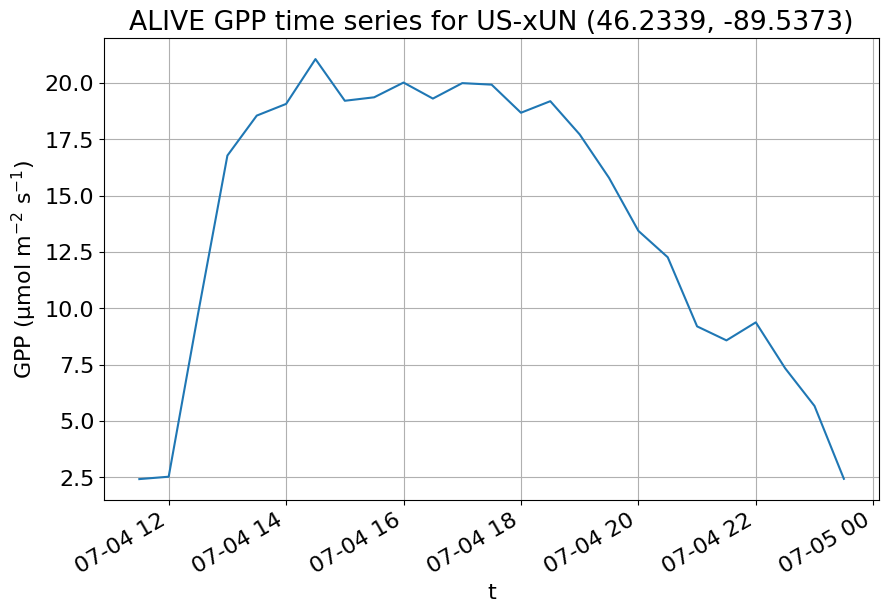

In [ ]:
plt.figure(figsize=(10, 6))
ds_daily['GPP'].plot()
plt.title(f'ALIVE GPP time series for US-xUN ({site_lat}, {site_lon})')
plt.ylabel('GPP (μmol m$^{-2}$ s$^{-1})$')
plt.grid(True)
plt.show()

Note that the model as currently implemented needs to be adjusted for residual nighttime issues. This will be a feature of future ALIVE models; for the moment these are set to zero for analysis purposes.

# Create an ALIVE Image

We can also plot individual ALIVE$_{GPP}$ images that correspond to single zarr library 'slices' in time. The image from noon on the 4$^{th}$ of July (Independence Day) is a great place to start.

In [ ]:
start_date = pd.to_datetime('2024-07-04 18:00')
end_date = pd.to_datetime('2024-07-04 19:00')
date_mask = (ds_2024['t'] >= start_date) & (ds_2024['t'] <= end_date)
oneDay = ds_2024['GPP'][date_mask] #& time_mask

year = 2024
day_of_year = 185 # July 4 (2024 is a leap year)
hour = 18 # UTC time is noon Central Standard Time
minute = 2 # ABI scans times are at 2,7,12,17,27,...57 mins after the hour

dt = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year, hours=hour, minutes = minute)

print(f"The converted datetime is: {dt}")

oneImage = oneDay.sel(t = dt, method="nearest")

#oneImage = oneDay.sel(t = dt)

The converted datetime is: 2024-07-04 18:02:00


ALIVE takes advantage of Google Cloud, and it's nice to be able to grab ABI imagery from the Google Cloud Platform to use its geographic information for plotting. ALIVE$_{GPP}$ uses the same coordinate projection. fsspec helps us do that while avoiding downloads to keep the workflow in the cloud and cartopy and metpy help with projections.

In [ ]:
# Get an ABI image from Google Cloud to parse its projection information
url = "https://storage.googleapis.com/gcp-public-data-goes-16/ABI-L2-BRFC/2022/164/16/OR_ABI-L2-BRFC-M6_G16_s20221641656172_e20221641658545_c20221641700372.nc"
fp2 = fsspec.open(url)
brfImg = xr.open_dataset(fp2.open(), engine="h5netcdf", mask_and_scale=True)
data = brfImg.metpy.parse_cf('BRF1')
geostationary = data.metpy.cartopy_crs

# Sweep the ABI data from the x (north/south) and y (east/west) axes
x = data.x
y = data.y

Creating individual images benefits from cartopy features like U.S. States, coastlines, and more. Note the use of '{}'.format(dt) for adding the timestamp to the header and the MATLAB-type syntax of matplotlib for details like fontweight='bold', fontsize=15.

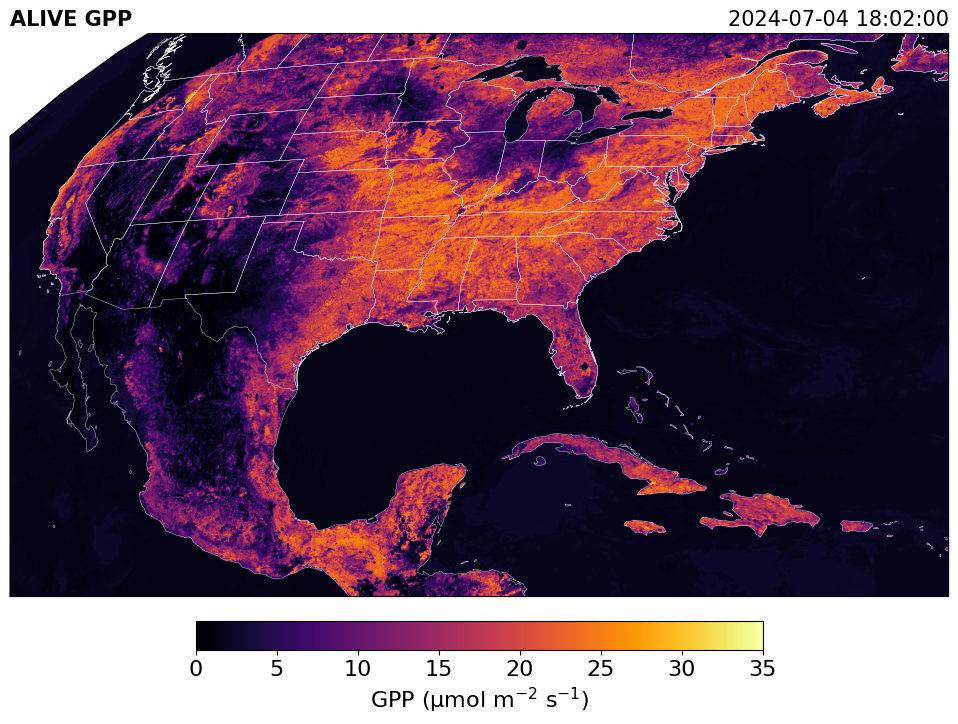

In [ ]:
# Use the geostationary projection to plot the image on a map
# This method streches the image across a map with the same projection and dimensions as the data

fig = plt.figure(figsize=(15, 8))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geostationary)

# Add the RGB True Color image to the figure. The data is in the same projection as the axis created
im = ax.imshow(oneImage, origin='upper', cmap=plt.cm.inferno, vmin = 0, vmax = 35,
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geostationary)

# Add coastlines and states
ax.coastlines(resolution='50m', color='white', linewidth=0.25)
ax.add_feature(ccrs.cartopy.feature.STATES, edgecolor= 'white', linewidth=0.25)

#Add title
plt.title('ALIVE GPP', loc='left', fontweight='bold', fontsize=15)
plt.title('{}'.format(dt), loc='right',fontsize=15)
cb = fig.colorbar(im, label='GPP (μmol m$^{-2}$ s$^{-1}$)', orientation='horizontal', fraction=0.046, pad=0.04)

plt.show()

# Create a one-day composite

We recognize that five-minute GPP estimates is probably too much information (TMI). An advantage to summing ALIVE data is that cloud and other atmospheric impacts on fluxes are integrated into the GPP flux estimate, which can avoid potential Jensen's Inequalities when scaling to daily or longer sums. We can define a start and end of a summation period:

In [ ]:
year = 2024
start_doy = 186 # JULIAN day
stop_doy = 187 # JULIAN day
start_hour = 10 # UTC time
end_hour = 2 # UTC time

start_dt = pd.to_datetime(f"{year}-01-01") + pd.DateOffset(days= start_doy - 1, hours=start_hour)
stop_dt = pd.to_datetime(f"{year}-01-01") + pd.DateOffset(days= stop_doy - 1, hours= end_hour)

print(f"The one-day composite will sum {start_dt} UTC to {stop_dt} UTC")

The one-day composite will sum 2024-07-04 10:00:00 UTC to 2024-07-05 02:00:00 UTC


and use time indexing to extract our time period from the entire library.

In [ ]:
date_mask = (ds_2024['t'] >= start_dt) & (ds_2024['t'] <= stop_dt)
oneDay = ds_2024['GPP'][date_mask]
oneDay

<xarray.DataArray 'GPP' (t: 192, y: 1500, x: 2500)>
[720000000 values with dtype=float64]
Coordinates:
  * t        (t) datetime64[ns] 2024-07-04T10:02:00 ... 2024-07-05T01:57:00
  * x        (x) float32 -0.1013 -0.1013 -0.1012 ... 0.0385 0.03856 0.03861
  * y        (y) float32 0.1282 0.1282 0.1281 0.128 ... 0.04438 0.04432 0.04427

Note that we still have 192 time slices for our chosen period, which is still difficult to average. Chunking the array along the time dimension (here choosing 10 time steps per chunk), and then summing the chunks, can shorten the run time.

In [ ]:
# Chunk along the time dimension (e.g., 10 time steps per chunk)
gpp_data_chunked = oneDay.chunk({'t': 10})

# Compute the sum of the chunks
gpp_sum = gpp_data_chunked.sum(dim='t')

#Convert units from umol/m2/sec to gC/m2/5 minutes for summation = 1 mol / 1e6 umol * 12.01 g C / 1 mol CO2 * 60 sec / 1 min * 5 min / (1 image)
converted_GPP = gpp_sum * 0.003603
converted_GPP.data

dask.array<mul, shape=(1500, 2500), dtype=float64, chunksize=(1500, 2500), chunktype=numpy.ndarray>

We can plot these summed data in the same way as before. I can confirm that the 4$^{th}$ of July had low GPP across much of Wisconsin, it was a rainy day.

Text(1.0, 1.0, '2024-07-04')

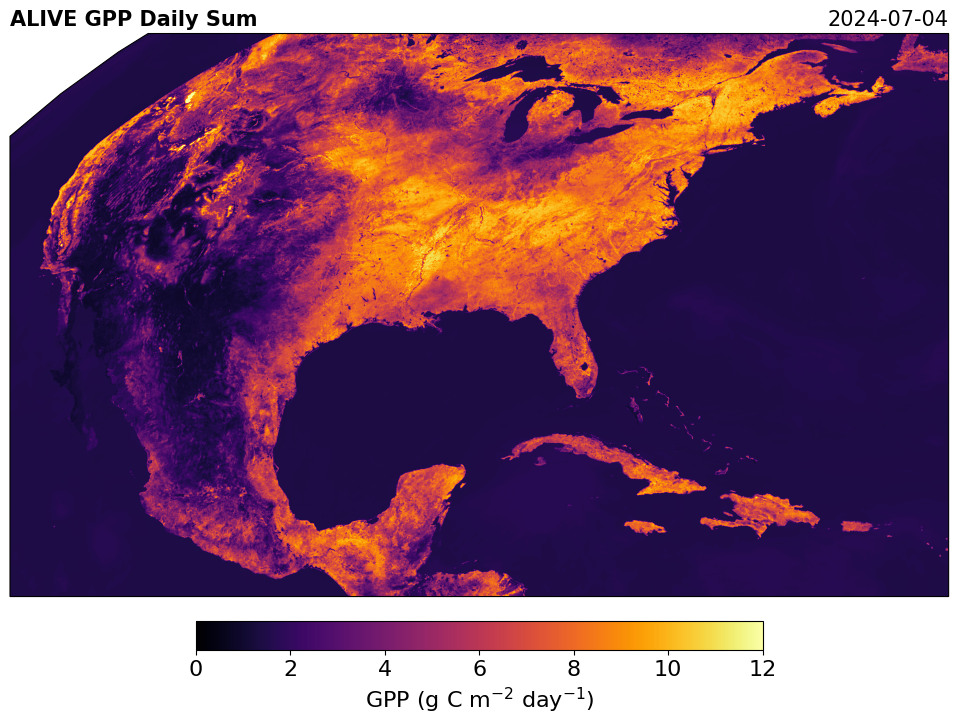

In [ ]:
fig = plt.figure(figsize=(15, 8))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geostationary)

# Add the ALIVE daily GPP sum image to the figure. The data is in the same projection as the axis created
im2 = ax.imshow(converted_GPP, origin='upper', cmap=plt.cm.inferno, vmin = 0, vmax = 12,
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geostationary)
cb = fig.colorbar(im2, label='GPP (g C m$^{-2}$ day$^{-1}$)', orientation='horizontal', fraction=0.046, pad=0.04,)
plt.title('ALIVE GPP Daily Sum', loc='left', fontweight='bold', fontsize=15)
plt.title('{}'.format(start_dt.date()), loc='right',fontsize=15)

# Create an ALIVE Loop

Individual images and sums are great to look at, but it can be more exciting to visualize by creating loops. To do so, first specify dates and dimensions (if subsetting to regions).

In [ ]:
year = 2024
start_doy = 186 # JULIAN day
stop_doy = 186 # JULIAN day
start_hour = 18 # UTC time
end_hour = 20 # UTC time

# Latitude and longitude extents of the frame
lat_west = -100
lat_east = -80
lon_south = 38
lon_north = 50

start_dt = pd.to_datetime(f"{year}-01-01") + pd.DateOffset(days= start_doy - 1, hours=start_hour)
stop_dt = pd.to_datetime(f"{year}-01-01") + pd.DateOffset(days= stop_doy - 1, hours= end_hour)
date_mask = (ds_2024['t'] >= start_dt) & (ds_2024['t'] <= stop_dt)
oneDay = ds_2024['GPP'][date_mask]

print(f"The loop will run from {start_dt} to {stop_dt} UTC")

The loop will run from 2024-07-04 18:00:00 to 2024-07-04 20:00:00 UTC


We need somewhere for the video to go. Mounting google drive to colab gives it that place (while staying in the cloud).

In [ ]:
from google.colab import drive
cg = '/content/drive'
drive.mount(cg)
path = '/content/drive/MyDrive/'
loopName = 'Fourth_of_July'

Mounted at /content/drive


The loop takes a few minutes, and should create an animation that demonstrates some of the clouds that passed over the US-xUN study area and the western Great Lakes region around local noon on the 4$^{th}$  of July.

For here, let's run it over lunch

2024-07-04 18:02:00
2024-07-04 18:07:00
2024-07-04 18:12:00
2024-07-04 18:17:00
2024-07-04 18:22:00
2024-07-04 18:27:00
2024-07-04 18:32:00
2024-07-04 18:37:00
2024-07-04 18:42:00
2024-07-04 18:47:00
2024-07-04 18:52:00
2024-07-04 18:57:00
2024-07-04 19:02:00
2024-07-04 19:07:00
2024-07-04 19:12:00
2024-07-04 19:17:00
2024-07-04 19:22:00
2024-07-04 19:27:00
2024-07-04 19:32:00
2024-07-04 19:37:00
2024-07-04 19:42:00
2024-07-04 19:47:00
2024-07-04 19:52:00
2024-07-04 19:57:00
VIDEO
2.9779800812403363 minutes


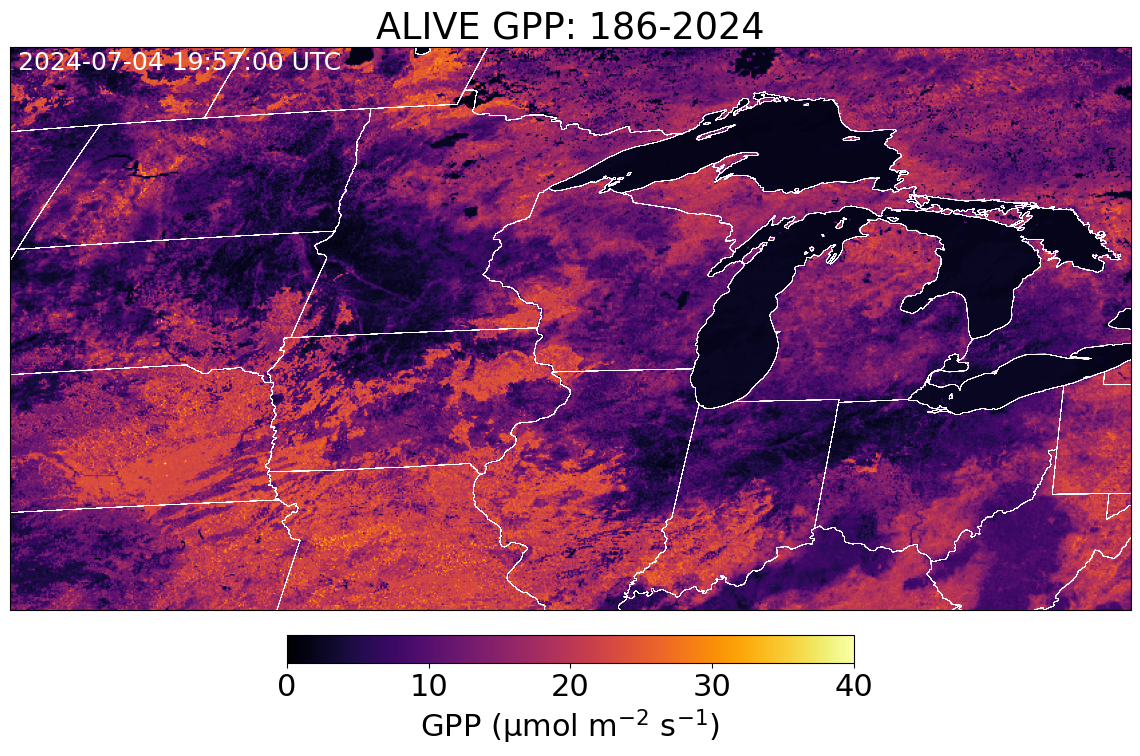

In [ ]:
start_time = time.time()
# Make ALIVE animation for day

#Set video visualization parameters
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['font.size'] = 22
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=geostationary)
plt.title('ALIVE GPP: ' + str(start_doy) + '-' + str(year))
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

#Loop through each timestamp in two-hour period
frames = []
oneframe = []
for timestamp in oneDay['t']:
    print(pd.to_datetime(timestamp.values).round('1s'))
    img = oneDay.sel(t=timestamp)
    im = ax.imshow(img, cmap=plt.cm.inferno, vmin = 0, vmax = 40, animated=True,
                   origin='upper',extent=(x.min(), x.max(), y.min(), y.max()), transform=geostationary)
    #Crop to the Midwestern region
    ax.set_extent([lat_west, lat_east, lon_south, lon_north], crs=ccrs.PlateCarree())

    # Add coastlines, states, and timestamp
    ax.coastlines(resolution='50m', color='white', linewidth=0.25)
    ax.add_feature(ccrs.cartopy.feature.STATES, edgecolor= 'white', linewidth=0.25)
    t = ax.annotate('{0} UTC'.format(pd.to_datetime(timestamp.values).round('1s')),(0.007,0.96), xycoords ='axes fraction', color = 'white', fontsize=18)
    oneframe = [im, t]
    frames.append(oneframe)

cb = fig.colorbar(im, label='GPP (μmol m$^{-2}$ s$^{-1}$)', orientation='horizontal', fraction=0.046, pad=0.04)

ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True)
ani.save(path + loopName + '_ALIVE_GPP_{day}_{year}.mp4'.format(day=start_doy, year=year))

print('VIDEO')
print(float(time.time() - start_time) / 60 , 'minutes')

That concludes our lesson, we hope you enjoyed it!
